In [1]:
!python -V

Python 3.9.19


In [2]:
import pandas as pd

In [3]:
import pickle

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [22]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment('my-first-experiment')

<Experiment: artifact_location='/workspaces/mlops-zoomcamp/02-experiment-tracking/mlruns/1', creation_time=1716562339297, experiment_id='1', last_update_time=1716562339297, lifecycle_stage='active', name='my-first-experiment', tags={}>

In [7]:
df = pd.read_parquet('./data/green_tripdata_2023-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [8]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


7.060351540140314

/tmp/ipykernel_24146/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_24146/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


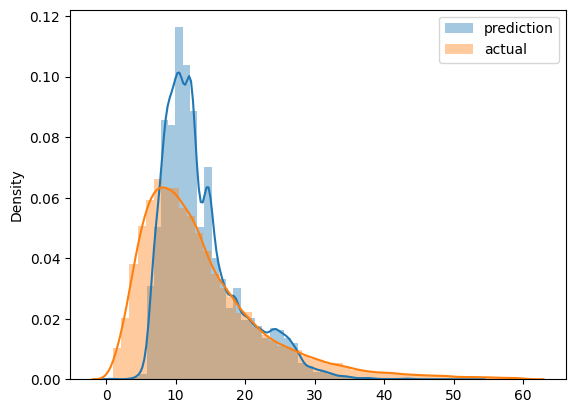

In [9]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [10]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [11]:
df_train = read_dataframe('./data/green_tripdata_2023-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2023-02.parquet')

In [12]:
len(df_train), len(df_val)

(65946, 62574)

In [13]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [14]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [15]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [16]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


6.03727552054262

In [17]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [19]:
with mlflow.start_run():
    
    mlflow.set_tag("developer", "francesca")
    
    mlflow.log_param("train-data-path", "./data/green_tripdata_2023-01.parquet")
    mlflow.log_param("val-data-path", "./data/green_tripdata_2023-02.parquet")
    
    alpha = 0.01
    mlflow.log_param('alpha', alpha)
    
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("RMSE", rmse)

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [18]:
import xgboost as xgb 

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [19]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [20]:

def objective(params):
    with mlflow.start_run():
        
        mlflow.set_tag("model","xgboost")
        mlflow.log_params(params)
        
        booster = xgb.train(
            params = params,
            dtrain = train,
            num_boost_round = 1000,
            evals = [(valid, "validation")],
            early_stopping_rounds = 50
        )
        
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("RMSE", rmse)
        
    return {'loss':rmse, 'status':STATUS_OK}
        


In [26]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 1307
}

In [27]:
best_result = fmin(
    fn=objective,
    space = search_space,
    algo = tpe.suggest,
    max_evals = 50,
    trials = Trials()
)

[0]	validation-rmse:8.14827                           
[1]	validation-rmse:7.31154                           
[2]	validation-rmse:6.72448                           
[3]	validation-rmse:6.32236                           
[4]	validation-rmse:6.05420                           
  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:17:52] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[5]	validation-rmse:5.87189                           
[6]	validation-rmse:5.74407                           
[7]	validation-rmse:5.66352                           
[8]	validation-rmse:5.60980                           
[9]	validation-rmse:5.57079                           
[10]	validation-rmse:5.54524                          
[11]	validation-rmse:5.52681                          
[12]	validation-rmse:5.51042                          
[13]	validation-rmse:5.50357                          
[14]	validation-rmse:5.49825                          
[15]	validation-rmse:5.49397                          
[16]	validation-rmse:5.48857                          
[17]	validation-rmse:5.48459                          
[18]	validation-rmse:5.48381                          
[19]	validation-rmse:5.48106                          
[20]	validation-rmse:5.47976                          
[21]	validation-rmse:5.47816                          
[22]	validation-rmse:5.47626                          
[23]	valid

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:18:23] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.67655                                                    
[1]	validation-rmse:6.66098                                                    
[2]	validation-rmse:6.06765                                                    
[3]	validation-rmse:5.72565                                                    
[4]	validation-rmse:5.52769                                                    
[5]	validation-rmse:5.41685                                                    
[6]	validation-rmse:5.34417                                                    
[7]	validation-rmse:5.30121                                                    
[8]	validation-rmse:5.27762                                                    
[9]	validation-rmse:5.25744                                                    
[10]	validation-rmse:5.24513                                                   
[11]	validation-rmse:5.23692                                                   
[12]	validation-rmse:5.23214            

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:18:41] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.72454                                                    
[1]	validation-rmse:5.71593                                                    
[2]	validation-rmse:5.37138                                                    
[3]	validation-rmse:5.25563                                                    
[4]	validation-rmse:5.20971                                                    
[5]	validation-rmse:5.19335                                                    
[6]	validation-rmse:5.18352                                                    
[7]	validation-rmse:5.17682                                                    
[8]	validation-rmse:5.17424                                                    
[9]	validation-rmse:5.17347                                                    
[10]	validation-rmse:5.17147                                                   
[11]	validation-rmse:5.17184                                                   
[12]	validation-rmse:5.17129            

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:18:55] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.36171                                                    
[1]	validation-rmse:6.31151                                                    
[2]	validation-rmse:5.78777                                                    
[3]	validation-rmse:5.53357                                                    
[4]	validation-rmse:5.40528                                                    
[5]	validation-rmse:5.33941                                                    
[6]	validation-rmse:5.30317                                                    
[7]	validation-rmse:5.28144                                                    
[8]	validation-rmse:5.26569                                                    
[9]	validation-rmse:5.25693                                                    
[10]	validation-rmse:5.24900                                                   
[11]	validation-rmse:5.24491                                                   
[12]	validation-rmse:5.23030            

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:19:15] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.47621                                                    
[1]	validation-rmse:7.78611                                                    
[2]	validation-rmse:7.22883                                                    
[3]	validation-rmse:6.78316                                                    
[4]	validation-rmse:6.43191                                                    
[5]	validation-rmse:6.15551                                                    
[6]	validation-rmse:5.94002                                                    
[7]	validation-rmse:5.77390                                                    
[8]	validation-rmse:5.64627                                                    
[9]	validation-rmse:5.54613                                                    
[10]	validation-rmse:5.47045                                                   
[11]	validation-rmse:5.41155                                                   
[12]	validation-rmse:5.36698            

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:20:01] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.07693                                                    
[1]	validation-rmse:5.38053                                                    
[2]	validation-rmse:5.24145                                                    
[3]	validation-rmse:5.20897                                                    
[4]	validation-rmse:5.19618                                                    
[5]	validation-rmse:5.19209                                                    
[6]	validation-rmse:5.18981                                                    
[7]	validation-rmse:5.18538                                                    
[8]	validation-rmse:5.18676                                                    
[9]	validation-rmse:5.18315                                                    
[10]	validation-rmse:5.18249                                                   
[11]	validation-rmse:5.17321                                                   
[12]	validation-rmse:5.17127            

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:20:14] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.31048                                                    
[1]	validation-rmse:5.62365                                                    
[2]	validation-rmse:5.46502                                                    
[3]	validation-rmse:5.40459                                                    
[4]	validation-rmse:5.38083                                                    
[5]	validation-rmse:5.35904                                                    
[6]	validation-rmse:5.33956                                                    
[7]	validation-rmse:5.32817                                                    
[8]	validation-rmse:5.32386                                                    
[9]	validation-rmse:5.32357                                                    
[10]	validation-rmse:5.31731                                                   
[11]	validation-rmse:5.31445                                                   
[12]	validation-rmse:5.31181            

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:20:38] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.58561                                                    
[1]	validation-rmse:5.71058                                                    
[2]	validation-rmse:5.43010                                                    
[3]	validation-rmse:5.34799                                                    
[4]	validation-rmse:5.29123                                                    
[5]	validation-rmse:5.27896                                                    
[6]	validation-rmse:5.27511                                                    
[7]	validation-rmse:5.27475                                                    
[8]	validation-rmse:5.27316                                                    
[9]	validation-rmse:5.26869                                                    
[10]	validation-rmse:5.26681                                                   
[11]	validation-rmse:5.26728                                                   
[12]	validation-rmse:5.26674            

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:20:52] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.47833                                                    
[1]	validation-rmse:7.79391                                                    
[2]	validation-rmse:7.24396                                                    
[3]	validation-rmse:6.80587                                                    
[4]	validation-rmse:6.46062                                                    
[5]	validation-rmse:6.19101                                                    
[6]	validation-rmse:5.98291                                                    
[7]	validation-rmse:5.82228                                                    
[8]	validation-rmse:5.69771                                                    
[9]	validation-rmse:5.60263                                                    
[10]	validation-rmse:5.52754                                                   
[11]	validation-rmse:5.46912                                                   
[12]	validation-rmse:5.42377            

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:21:49] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.00282                                                    
[1]	validation-rmse:8.70592                                                    
[2]	validation-rmse:8.43014                                                    
[3]	validation-rmse:8.17670                                                    
[4]	validation-rmse:7.94032                                                    
[5]	validation-rmse:7.72319                                                    
[6]	validation-rmse:7.52208                                                    
[7]	validation-rmse:7.33744                                                    
[8]	validation-rmse:7.16668                                                    
[9]	validation-rmse:7.01018                                                    
[10]	validation-rmse:6.86593                                                   
[11]	validation-rmse:6.73355                                                   
[12]	validation-rmse:6.60974            

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[0]	validation-rmse:8.72342                                                     
 20%|██        | 10/50 [05:00<27:40, 41.51s/trial, best loss: 5.123687980773988]

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:22:52] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:8.20720                                                     
[2]	validation-rmse:7.76433                                                     
[3]	validation-rmse:7.38627                                                     
[4]	validation-rmse:7.06481                                                     
[5]	validation-rmse:6.79202                                                     
[6]	validation-rmse:6.56264                                                     
[7]	validation-rmse:6.37072                                                     
[8]	validation-rmse:6.21041                                                     
[9]	validation-rmse:6.07735                                                     
[10]	validation-rmse:5.96645                                                    
[11]	validation-rmse:5.87496                                                    
[12]	validation-rmse:5.79941                                                    
[13]	validation-rmse:5.73522

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:23:47] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.78805                                                     
[1]	validation-rmse:5.75452                                                     
[2]	validation-rmse:5.38121                                                     
[3]	validation-rmse:5.24797                                                     
[4]	validation-rmse:5.19903                                                     
[5]	validation-rmse:5.18424                                                     
[6]	validation-rmse:5.17406                                                     
[7]	validation-rmse:5.16764                                                     
[8]	validation-rmse:5.16655                                                     
[9]	validation-rmse:5.15903                                                     
[10]	validation-rmse:5.15937                                                    
[11]	validation-rmse:5.15832                                                    
[12]	validation-rmse:5.15790

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:24:00] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.86915                                                     
[1]	validation-rmse:8.46201                                                     
[2]	validation-rmse:8.09921                                                     
[3]	validation-rmse:7.77319                                                     
[4]	validation-rmse:7.48428                                                     
[5]	validation-rmse:7.22288                                                     
[6]	validation-rmse:6.99005                                                     
[7]	validation-rmse:6.79050                                                     
[8]	validation-rmse:6.60377                                                     
[9]	validation-rmse:6.44314                                                     
[10]	validation-rmse:6.30282                                                    
[11]	validation-rmse:6.18119                                                    
[12]	validation-rmse:6.07140

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:24:54] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.07630                                                     
[1]	validation-rmse:6.07190                                                     
[2]	validation-rmse:5.66160                                                     
[3]	validation-rmse:5.48832                                                     
[4]	validation-rmse:5.40863                                                     
[5]	validation-rmse:5.36815                                                     
[6]	validation-rmse:5.34175                                                     
[7]	validation-rmse:5.32662                                                     
[8]	validation-rmse:5.31578                                                     
[9]	validation-rmse:5.30836                                                     
[10]	validation-rmse:5.29917                                                    
[11]	validation-rmse:5.28687                                                    
[12]	validation-rmse:5.28654

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:25:17] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.52459                                                     
[1]	validation-rmse:7.86964                                                     
[2]	validation-rmse:7.33806                                                     
[3]	validation-rmse:6.90826                                                     
[4]	validation-rmse:6.56618                                                     
[5]	validation-rmse:6.29251                                                     
[6]	validation-rmse:6.07604                                                     
[7]	validation-rmse:5.90519                                                     
[8]	validation-rmse:5.77173                                                     
[9]	validation-rmse:5.66720                                                     
[10]	validation-rmse:5.58524                                                    
[11]	validation-rmse:5.52049                                                    
[12]	validation-rmse:5.46806

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:25:46] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.87693                                                     
[1]	validation-rmse:6.90103                                                     
[2]	validation-rmse:6.25982                                                     
[3]	validation-rmse:5.84929                                                     
[4]	validation-rmse:5.59454                                                     
[5]	validation-rmse:5.43244                                                     
[6]	validation-rmse:5.33814                                                     
[7]	validation-rmse:5.27772                                                     
[8]	validation-rmse:5.24064                                                     
[9]	validation-rmse:5.21826                                                     
[10]	validation-rmse:5.20215                                                    
[11]	validation-rmse:5.19178                                                    
[12]	validation-rmse:5.18470

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:26:11] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.70652                                                     
[1]	validation-rmse:8.17419                                                     
[2]	validation-rmse:7.71505                                                     
[3]	validation-rmse:7.32215                                                     
[4]	validation-rmse:6.98727                                                     
[5]	validation-rmse:6.70347                                                     
[6]	validation-rmse:6.46380                                                     
[7]	validation-rmse:6.26257                                                     
[8]	validation-rmse:6.09401                                                     
[9]	validation-rmse:5.95333                                                     
[10]	validation-rmse:5.83687                                                    
[11]	validation-rmse:5.73908                                                    
[12]	validation-rmse:5.65778

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:27:06] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.22453                                                     
[1]	validation-rmse:7.39135                                                     
[2]	validation-rmse:6.77026                                                     
[3]	validation-rmse:6.31550                                                     
[4]	validation-rmse:5.98748                                                     
[5]	validation-rmse:5.75061                                                     
[6]	validation-rmse:5.58288                                                     
[7]	validation-rmse:5.46654                                                     
[8]	validation-rmse:5.38550                                                     
[9]	validation-rmse:5.32556                                                     
[10]	validation-rmse:5.28438                                                    
[11]	validation-rmse:5.25410                                                    
[12]	validation-rmse:5.23373

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:27:45] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.17192                                                     
[1]	validation-rmse:6.14015                                                     
[2]	validation-rmse:5.64270                                                     
[3]	validation-rmse:5.46096                                                     
[4]	validation-rmse:5.38653                                                     
[5]	validation-rmse:5.33799                                                     
[6]	validation-rmse:5.32833                                                     
[7]	validation-rmse:5.32389                                                     
[8]	validation-rmse:5.31589                                                     
[9]	validation-rmse:5.30983                                                     
[10]	validation-rmse:5.30255                                                    
[11]	validation-rmse:5.29712                                                    
[12]	validation-rmse:5.29885

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:28:04] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.67484                                                     
[1]	validation-rmse:8.12183                                                     
[2]	validation-rmse:7.65411                                                     
[3]	validation-rmse:7.24979                                                     
[4]	validation-rmse:6.91691                                                     
[5]	validation-rmse:6.62911                                                     
[6]	validation-rmse:6.40211                                                     
[7]	validation-rmse:6.20403                                                     
[8]	validation-rmse:6.04445                                                     
[9]	validation-rmse:5.90952                                                     
[10]	validation-rmse:5.79931                                                    
[11]	validation-rmse:5.71355                                                    
[12]	validation-rmse:5.63965

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:28:49] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:5.39767                                                     
[1]	validation-rmse:5.23651                                                     
[2]	validation-rmse:5.22609                                                     
[3]	validation-rmse:5.22817                                                     
[4]	validation-rmse:5.21767                                                     
[5]	validation-rmse:5.21461                                                     
[6]	validation-rmse:5.21614                                                     
[7]	validation-rmse:5.21965                                                     
[8]	validation-rmse:5.21628                                                     
[9]	validation-rmse:5.21895                                                     
[10]	validation-rmse:5.21693                                                    
[11]	validation-rmse:5.20660                                                    
[12]	validation-rmse:5.20669

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:28:58] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.82108                                                     
[1]	validation-rmse:6.82610                                                     
[2]	validation-rmse:6.19113                                                     
[3]	validation-rmse:5.79905                                                     
[4]	validation-rmse:5.55525                                                     
[5]	validation-rmse:5.40809                                                     
[6]	validation-rmse:5.32148                                                     
[7]	validation-rmse:5.26502                                                     
[8]	validation-rmse:5.23485                                                     
[9]	validation-rmse:5.21561                                                     
[10]	validation-rmse:5.20024                                                    
[11]	validation-rmse:5.19123                                                    
[12]	validation-rmse:5.18633

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[0]	validation-rmse:8.19586                                                     
 44%|████▍     | 22/50 [11:32<12:49, 27.47s/trial, best loss: 5.123687980773988]

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:29:24] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:7.36783                                                     
[2]	validation-rmse:6.77033                                                     
[3]	validation-rmse:6.34589                                                     
[4]	validation-rmse:6.04359                                                     
[5]	validation-rmse:5.83608                                                     
[6]	validation-rmse:5.69065                                                     
[7]	validation-rmse:5.58641                                                     
[8]	validation-rmse:5.51571                                                     
[9]	validation-rmse:5.46481                                                     
[10]	validation-rmse:5.42779                                                    
[11]	validation-rmse:5.39938                                                    
[12]	validation-rmse:5.37729                                                    
[13]	validation-rmse:5.36342

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[0]	validation-rmse:7.82861                                                     
[1]	validation-rmse:6.90167                                                     
[2]	validation-rmse:6.34354                                                     
[3]	validation-rmse:6.01397                                                     
 46%|████▌     | 23/50 [12:02<12:44, 28.31s/trial, best loss: 5.123687980773988]

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:29:54] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[4]	validation-rmse:5.82778                                                     
[5]	validation-rmse:5.71593                                                     
[6]	validation-rmse:5.64621                                                     
[7]	validation-rmse:5.60700                                                     
[8]	validation-rmse:5.57843                                                     
[9]	validation-rmse:5.56359                                                     
[10]	validation-rmse:5.54632                                                    
[11]	validation-rmse:5.53337                                                    
[12]	validation-rmse:5.52800                                                    
[13]	validation-rmse:5.52244                                                    
[14]	validation-rmse:5.51822                                                    
[15]	validation-rmse:5.51529                                                    
[16]	validation-rmse:5.51422

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:30:22] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.56803                                                     
[1]	validation-rmse:6.56024                                                     
[2]	validation-rmse:6.01991                                                     
[3]	validation-rmse:5.71684                                                     
[4]	validation-rmse:5.55584                                                     
[5]	validation-rmse:5.47275                                                     
[6]	validation-rmse:5.42647                                                     
[7]	validation-rmse:5.39804                                                     
[8]	validation-rmse:5.38501                                                     
[9]	validation-rmse:5.37502                                                     
[10]	validation-rmse:5.36583                                                    
[11]	validation-rmse:5.36124                                                    
[12]	validation-rmse:5.36007

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:30:35] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.27105                                                     
[1]	validation-rmse:7.47764                                                     
[2]	validation-rmse:6.89161                                                     
[3]	validation-rmse:6.46800                                                     
[4]	validation-rmse:6.15129                                                     
[5]	validation-rmse:5.92987                                                     
[6]	validation-rmse:5.76940                                                     
[7]	validation-rmse:5.65706                                                     
[8]	validation-rmse:5.57283                                                     
[9]	validation-rmse:5.51270                                                     
[10]	validation-rmse:5.47033                                                    
[11]	validation-rmse:5.43745                                                    
[12]	validation-rmse:5.41300

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:31:08] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.86325                                                     
[1]	validation-rmse:8.45042                                                     
[2]	validation-rmse:8.07957                                                     
[3]	validation-rmse:7.74712                                                     
[4]	validation-rmse:7.44954                                                     
[5]	validation-rmse:7.18557                                                     
[6]	validation-rmse:6.95098                                                     
[7]	validation-rmse:6.74183                                                     
[8]	validation-rmse:6.55608                                                     
[9]	validation-rmse:6.39161                                                     
[10]	validation-rmse:6.24875                                                    
[11]	validation-rmse:6.12223                                                    
[12]	validation-rmse:6.01097

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[0]	validation-rmse:5.49969                                                     


/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:32:06] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:5.48359
[2]	validation-rmse:5.46478                                                     
[3]	validation-rmse:5.44429                                                     
[4]	validation-rmse:5.42942                                                     
[5]	validation-rmse:5.42260                                                     
[6]	validation-rmse:5.40992                                                     
[7]	validation-rmse:5.40292                                                     
[8]	validation-rmse:5.39720                                                     
[9]	validation-rmse:5.38924                                                     
[10]	validation-rmse:5.38718                                                    
[11]	validation-rmse:5.38078                                                    
[12]	validation-rmse:5.37703                                                    
[13]	validation-rmse:5.37272                                                    


/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[0]	validation-rmse:8.22977                                                     
[1]	validation-rmse:7.43915                                                     
[2]	validation-rmse:6.87125                                                     
[3]	validation-rmse:6.47720                                                     
[4]	validation-rmse:6.20549                                                     
[5]	validation-rmse:6.02110                                                     
 56%|█████▌    | 28/50 [14:22<10:05, 27.54s/trial, best loss: 5.123687980773988]

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:32:14] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[6]	validation-rmse:5.89191                                                     
[7]	validation-rmse:5.80381                                                     
[8]	validation-rmse:5.74513                                                     
[9]	validation-rmse:5.70123                                                     
[10]	validation-rmse:5.67308                                                    
[11]	validation-rmse:5.65150                                                    
[12]	validation-rmse:5.63204                                                    
[13]	validation-rmse:5.62241                                                    
[14]	validation-rmse:5.61391                                                    
[15]	validation-rmse:5.60409                                                    
[16]	validation-rmse:5.59890                                                    
[17]	validation-rmse:5.59232                                                    
[18]	validation-rmse:5.58606

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:32:40] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:5.76535                                                     
[1]	validation-rmse:5.34367                                                     
[2]	validation-rmse:5.27692                                                     
[3]	validation-rmse:5.25226                                                     
[4]	validation-rmse:5.24584                                                     
[5]	validation-rmse:5.23862                                                     
[6]	validation-rmse:5.22985                                                     
[7]	validation-rmse:5.22683                                                     
[8]	validation-rmse:5.22049                                                     
[9]	validation-rmse:5.21769                                                     
[10]	validation-rmse:5.21278                                                    
[11]	validation-rmse:5.20951                                                    
[12]	validation-rmse:5.20130

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:32:50] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.61914                                                     
[1]	validation-rmse:6.60391                                                     
[2]	validation-rmse:6.03263                                                     
[3]	validation-rmse:5.70970                                                     
[4]	validation-rmse:5.53264                                                     
[5]	validation-rmse:5.43500                                                     
[6]	validation-rmse:5.37594                                                     
[7]	validation-rmse:5.33701                                                     
[8]	validation-rmse:5.31247                                                     
[9]	validation-rmse:5.29786                                                     
[10]	validation-rmse:5.28572                                                    
[11]	validation-rmse:5.27770                                                    
[12]	validation-rmse:5.27464

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[0]	validation-rmse:8.29441                                                     
[1]	validation-rmse:7.52093                                                     
 62%|██████▏   | 31/50 [15:13<06:22, 20.11s/trial, best loss: 5.123687980773988]

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:33:06] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:6.94266                                                     
[3]	validation-rmse:6.52018                                                     
[4]	validation-rmse:6.21386                                                     
[5]	validation-rmse:5.99600                                                     
[6]	validation-rmse:5.84105                                                     
[7]	validation-rmse:5.72926                                                     
[8]	validation-rmse:5.64668                                                     
[9]	validation-rmse:5.59240                                                     
[10]	validation-rmse:5.55127                                                    
[11]	validation-rmse:5.51721                                                    
[12]	validation-rmse:5.49408                                                    
[13]	validation-rmse:5.47791                                                    
[14]	validation-rmse:5.46613

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:33:35] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.39112                                                     
[1]	validation-rmse:7.65755                                                     
[2]	validation-rmse:7.08741                                                     
[3]	validation-rmse:6.65000                                                     
[4]	validation-rmse:6.31697                                                     
[5]	validation-rmse:6.06520                                                     
[6]	validation-rmse:5.87750                                                     
[7]	validation-rmse:5.73769                                                     
[8]	validation-rmse:5.63187                                                     
[9]	validation-rmse:5.55537                                                     
[10]	validation-rmse:5.49304                                                    
[11]	validation-rmse:5.44935                                                    
[12]	validation-rmse:5.41461

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:34:26] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.34268                                                     
[1]	validation-rmse:6.29817                                                     
[2]	validation-rmse:5.76662                                                     
[3]	validation-rmse:5.51354                                                     
[4]	validation-rmse:5.38666                                                     
[5]	validation-rmse:5.32080                                                     
[6]	validation-rmse:5.28281                                                     
[7]	validation-rmse:5.25513                                                     
[8]	validation-rmse:5.24443                                                     
[9]	validation-rmse:5.23529                                                     
[10]	validation-rmse:5.23237                                                    
[11]	validation-rmse:5.23180                                                    
[12]	validation-rmse:5.22807

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:34:39] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.37225                                                     
[1]	validation-rmse:5.51527                                                     
[2]	validation-rmse:5.29973                                                     
[3]	validation-rmse:5.24133                                                     
[4]	validation-rmse:5.21128                                                     
[5]	validation-rmse:5.19894                                                     
[6]	validation-rmse:5.19695                                                     
[7]	validation-rmse:5.19603                                                     
[8]	validation-rmse:5.19387                                                     
[9]	validation-rmse:5.19053                                                     
[10]	validation-rmse:5.18960                                                    
[11]	validation-rmse:5.19153                                                    
[12]	validation-rmse:5.19063

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[0]	validation-rmse:8.07989                                                     
[1]	validation-rmse:7.20909                                                     
 70%|███████   | 35/50 [16:58<05:21, 21.42s/trial, best loss: 5.123687980773988]

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:34:50] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:6.61143                                                     
[3]	validation-rmse:6.20887                                                     
[4]	validation-rmse:5.94124                                                     
[5]	validation-rmse:5.76562                                                     
[6]	validation-rmse:5.64472                                                     
[7]	validation-rmse:5.56530                                                     
[8]	validation-rmse:5.51186                                                     
[9]	validation-rmse:5.47218                                                     
[10]	validation-rmse:5.44356                                                    
[11]	validation-rmse:5.42011                                                    
[12]	validation-rmse:5.40771                                                    
[13]	validation-rmse:5.39279                                                    
[14]	validation-rmse:5.38256

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[0]	validation-rmse:7.87926                                                     
[1]	validation-rmse:6.95061                                                     
[2]	validation-rmse:6.36364                                                     
 72%|███████▏  | 36/50 [17:32<05:51, 25.13s/trial, best loss: 5.109297243637704]

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:35:24] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:6.01252                                                     
[4]	validation-rmse:5.79578                                                     
[5]	validation-rmse:5.66464                                                     
[6]	validation-rmse:5.57839                                                     
[7]	validation-rmse:5.52717                                                     
[8]	validation-rmse:5.49553                                                     
[9]	validation-rmse:5.47243                                                     
[10]	validation-rmse:5.45270                                                    
[11]	validation-rmse:5.44019                                                    
[12]	validation-rmse:5.43194                                                    
[13]	validation-rmse:5.42520                                                    
[14]	validation-rmse:5.42331                                                    
[15]	validation-rmse:5.41918

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[0]	validation-rmse:8.02730                                                     
[1]	validation-rmse:7.14149                                                     
[2]	validation-rmse:6.55193                                                     
[3]	validation-rmse:6.17291                                                     
[4]	validation-rmse:5.92615                                                     
[5]	validation-rmse:5.76926                                                     
 74%|███████▍  | 37/50 [18:02<05:47, 26.72s/trial, best loss: 5.109297243637704]

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:35:54] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[6]	validation-rmse:5.66700                                                     
[7]	validation-rmse:5.60175                                                     
[8]	validation-rmse:5.55633                                                     
[9]	validation-rmse:5.52672                                                     
[10]	validation-rmse:5.50038                                                    
[11]	validation-rmse:5.48780                                                    
[12]	validation-rmse:5.47906                                                    
[13]	validation-rmse:5.46865                                                    
[14]	validation-rmse:5.45681                                                    
[15]	validation-rmse:5.45059                                                    
[16]	validation-rmse:5.44745                                                    
[17]	validation-rmse:5.44303                                                    
[18]	validation-rmse:5.44013

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:36:23] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.56733                                                     
[1]	validation-rmse:7.94156                                                     
[2]	validation-rmse:7.42584                                                     
[3]	validation-rmse:7.00597                                                     
[4]	validation-rmse:6.66357                                                     
[5]	validation-rmse:6.38707                                                     
[6]	validation-rmse:6.16427                                                     
[7]	validation-rmse:5.98714                                                     
[8]	validation-rmse:5.84551                                                     
[9]	validation-rmse:5.73286                                                     
[10]	validation-rmse:5.64392                                                    
[11]	validation-rmse:5.57314                                                    
[12]	validation-rmse:5.51620

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:37:03] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:5.87329                                                     
[1]	validation-rmse:5.39592                                                     
[2]	validation-rmse:5.31423                                                     
[3]	validation-rmse:5.28741                                                     
[4]	validation-rmse:5.27618                                                     
[5]	validation-rmse:5.25881                                                     
[6]	validation-rmse:5.24752                                                     
[7]	validation-rmse:5.24326                                                     
[8]	validation-rmse:5.23728                                                     
[9]	validation-rmse:5.23161                                                     
[10]	validation-rmse:5.23046                                                    
[11]	validation-rmse:5.22580                                                    
[12]	validation-rmse:5.22459

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[0]	validation-rmse:8.85421                                                     
 80%|████████  | 40/50 [19:21<04:10, 25.05s/trial, best loss: 5.109297243637704]

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:37:14] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:8.43749                                                     
[2]	validation-rmse:8.06666                                                     
[3]	validation-rmse:7.73730                                                     
[4]	validation-rmse:7.44476                                                     
[5]	validation-rmse:7.18816                                                     
[6]	validation-rmse:6.96231                                                     
[7]	validation-rmse:6.76391                                                     
[8]	validation-rmse:6.58943                                                     
[9]	validation-rmse:6.43706                                                     
[10]	validation-rmse:6.30405                                                    
[11]	validation-rmse:6.18847                                                    
[12]	validation-rmse:6.08749                                                    
[13]	validation-rmse:5.99912

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:37:47] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.40065                                                     
[1]	validation-rmse:7.66631                                                     
[2]	validation-rmse:7.08921                                                     
[3]	validation-rmse:6.64171                                                     
[4]	validation-rmse:6.29382                                                     
[5]	validation-rmse:6.03033                                                     
[6]	validation-rmse:5.82749                                                     
[7]	validation-rmse:5.67559                                                     
[8]	validation-rmse:5.56012                                                     
[9]	validation-rmse:5.47141                                                     
[10]	validation-rmse:5.40711                                                    
[11]	validation-rmse:5.35855                                                    
[12]	validation-rmse:5.31876

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:38:17] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.69885                                                     
[1]	validation-rmse:5.75402                                                     
[2]	validation-rmse:5.47136                                                     
[3]	validation-rmse:5.37598                                                     
[4]	validation-rmse:5.33551                                                     
[5]	validation-rmse:5.31974                                                     
[6]	validation-rmse:5.30734                                                     
[7]	validation-rmse:5.30245                                                     
[8]	validation-rmse:5.30280                                                     
[9]	validation-rmse:5.29310                                                     
[10]	validation-rmse:5.28994                                                    
[11]	validation-rmse:5.28836                                                    
[12]	validation-rmse:5.28685

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:38:29] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.00054                                                     
[1]	validation-rmse:8.70219                                                     
[2]	validation-rmse:8.42576                                                     
[3]	validation-rmse:8.16997                                                     
[4]	validation-rmse:7.93375                                                     
[5]	validation-rmse:7.71567                                                     
[6]	validation-rmse:7.51447                                                     
[7]	validation-rmse:7.32909                                                     
[8]	validation-rmse:7.15897                                                     
[9]	validation-rmse:7.00229                                                     
[10]	validation-rmse:6.85846                                                    
[11]	validation-rmse:6.72721                                                    
[12]	validation-rmse:6.60682

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:39:33] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.94826                                                     
[1]	validation-rmse:8.60532                                                     
[2]	validation-rmse:8.29134                                                     
[3]	validation-rmse:8.00370                                                     
[4]	validation-rmse:7.74139                                                     
[5]	validation-rmse:7.50285                                                     
[6]	validation-rmse:7.28559                                                     
[7]	validation-rmse:7.08829                                                     
[8]	validation-rmse:6.90942                                                     
[9]	validation-rmse:6.74775                                                     
[10]	validation-rmse:6.60124                                                    
[11]	validation-rmse:6.46867                                                    
[12]	validation-rmse:6.34966

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[0]	validation-rmse:8.84541                                                     
[1]	validation-rmse:8.42494                                                     
[2]	validation-rmse:8.05293                                                     
[3]	validation-rmse:7.72646                                                     
[4]	validation-rmse:7.44124                                                     
 90%|█████████ | 45/50 [22:35<03:26, 41.22s/trial, best loss: 5.109297243637704]

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:40:28] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[5]	validation-rmse:7.19083                                                     
[6]	validation-rmse:6.97238                                                     
[7]	validation-rmse:6.78329                                                     
[8]	validation-rmse:6.62129                                                     
[9]	validation-rmse:6.48010                                                     
[10]	validation-rmse:6.35698                                                    
[11]	validation-rmse:6.25164                                                    
[12]	validation-rmse:6.16000                                                    
[13]	validation-rmse:6.08205                                                    
[14]	validation-rmse:6.01471                                                    
[15]	validation-rmse:5.95944                                                    
[16]	validation-rmse:5.91098                                                    
[17]	validation-rmse:5.86991

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:40:53] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.61726                                                     
[1]	validation-rmse:8.02791                                                     
[2]	validation-rmse:7.53844                                                     
[3]	validation-rmse:7.13502                                                     
[4]	validation-rmse:6.80455                                                     
[5]	validation-rmse:6.53607                                                     
[6]	validation-rmse:6.31762                                                     
[7]	validation-rmse:6.14202                                                     
[8]	validation-rmse:6.00082                                                     
[9]	validation-rmse:5.88847                                                     
[10]	validation-rmse:5.79865                                                    
[11]	validation-rmse:5.72708                                                    
[12]	validation-rmse:5.67034

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[0]	validation-rmse:7.83747                                                     
[1]	validation-rmse:6.88917                                                     
 94%|█████████▍| 47/50 [24:07<02:16, 45.61s/trial, best loss: 5.109297243637704]

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:42:00] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:6.30066                                                     
[3]	validation-rmse:5.95407                                                     
[4]	validation-rmse:5.74396                                                     
[5]	validation-rmse:5.61634                                                     
[6]	validation-rmse:5.54149                                                     
[7]	validation-rmse:5.48740                                                     
[8]	validation-rmse:5.45843                                                     
[9]	validation-rmse:5.44163                                                     
[10]	validation-rmse:5.41904                                                    
[11]	validation-rmse:5.40970                                                    
[12]	validation-rmse:5.40525                                                    
[13]	validation-rmse:5.39994                                                    
[14]	validation-rmse:5.39653

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:42:28] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.32781                                                     
[1]	validation-rmse:6.25600                                                     
[2]	validation-rmse:5.71654                                                     
[3]	validation-rmse:5.44565                                                     
[4]	validation-rmse:5.31763                                                     
[5]	validation-rmse:5.25157                                                     
[6]	validation-rmse:5.21782                                                     
[7]	validation-rmse:5.19946                                                     
[8]	validation-rmse:5.18973                                                     
[9]	validation-rmse:5.18248                                                     
[10]	validation-rmse:5.17580                                                    
[11]	validation-rmse:5.17119                                                    
[12]	validation-rmse:5.16911

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:42:46] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.03339                                                     
[1]	validation-rmse:6.03218                                                     
[2]	validation-rmse:5.62028                                                     
[3]	validation-rmse:5.44829                                                     
[4]	validation-rmse:5.36813                                                     
[5]	validation-rmse:5.32783                                                     
[6]	validation-rmse:5.31184                                                     
[7]	validation-rmse:5.30173                                                     
[8]	validation-rmse:5.29744                                                     
[9]	validation-rmse:5.29263                                                     
[10]	validation-rmse:5.28730                                                    
[11]	validation-rmse:5.28339                                                    
[12]	validation-rmse:5.27972

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



In [23]:
params = {
    "learning_rate": 0.28432383782454806,
    "max_depth" : 23,
    "min_child_weight" : 3.365937653014594,
    "objective" : "reg:linear",
    "reg_alpha" : 0.04231014882932197,
    "reg_lambda" : 0.0658418104939819,
    "seed" : 1307
}

mlflow.xgboost.autolog()

booster = xgb.train(
            params = params,
            dtrain = train,
            num_boost_round = 1000,
            evals = [(valid, "validation")],
            early_stopping_rounds = 50
        )

2024/05/27 17:38:29 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'd205702881594827b5b12cf53d1c9396', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow
/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [17:38:30] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:7.67655
[1]	validation-rmse:6.66098
[2]	validation-rmse:6.06765
[3]	validation-rmse:5.72565
[4]	validation-rmse:5.52769
[5]	validation-rmse:5.41685
[6]	validation-rmse:5.34417
[7]	validation-rmse:5.30121
[8]	validation-rmse:5.27762
[9]	validation-rmse:5.25744
[10]	validation-rmse:5.24513
[11]	validation-rmse:5.23692
[12]	validation-rmse:5.23214
[13]	validation-rmse:5.22834
[14]	validation-rmse:5.22577
[15]	validation-rmse:5.22079
[16]	validation-rmse:5.21873
[17]	validation-rmse:5.21763
[18]	validation-rmse:5.21617
[19]	validation-rmse:5.21382
[20]	validation-rmse:5.21156
[21]	validation-rmse:5.20974
[22]	validation-rmse:5.20717
[23]	validation-rmse:5.20530
[24]	validation-rmse:5.20006
[25]	validation-rmse:5.19951
[26]	validation-rmse:5.19799
[27]	validation-rmse:5.19584
[28]	validation-rmse:5.19487
[29]	validation-rmse:5.19378
[30]	validation-rmse:5.19133
[31]	validation-rmse:5.19046
[32]	validation-rmse:5.19000
[33]	validation-rmse:5.18961
[34]	validation-rmse:5.1

2024/05/27 17:38:53 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2024/05/27 17:38:53 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [17:38:53] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."
2024/05/27 17:38:55 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behav